In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, rc, rcParams
import seaborn as sns
from scipy.stats import gaussian_kde
import pandas as pd
import matplotlib
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import corner

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [94]:
import h5py

In [2]:
from tqdm import tqdm

In [3]:
import corner_plot_settings as pltu_corn
import plot_utils as pltu
from UNITS import *

In [4]:
import scipy.integrate as integrate
from scipy.interpolate import interp1d

In [5]:
import json

In [6]:
pltu.plot_settings(rc, rcParams)

In [7]:
GW241011_data_file = 'GW241011_GW241110_data_release/data/ancestors/GW241011_ancestral_properties_forwards.json'
GW241110_data_file = 'GW241011_GW241110_data_release/data/ancestors/GW241110_ancestral_properties_forwards.json'

In [96]:
GW241011_post_file = 'GW241011_GW241110_data_release/data/standard_pe/GW241011_posterior_samples_combined.h5'

In [98]:
GW241011_dat = h5py.File(GW241011_post_file,'r')

In [104]:
GW241011_dat['C00:Mixed'].keys()

<KeysViewHDF5 ['meta_data', 'posterior_samples']>

In [124]:
#GW241011_dat['C00:Mixed']['posterior_samples'][0:]

In [134]:
def lousto_kick(q, s1x, s1y, s1z, s2x, s2y, s2z):
    """
    Vectorized Lousto & Zlochower (2011) recoil kick formula.
    All inputs are 1D numpy arrays of the same length.
    Returns magnitudes of kick velocity arrays (km/s).
    """

    # Constants (Lousto+2011)
    A = 1.2e4  # km/s
    B = -0.93
    H = 6.9e3
    K = 6.0e4
    xi = np.deg2rad(145)

    # Symmetric mass ratio
    eta = q / (1 + q)**2

    # Spin difference vector Delta = S2/m2 - S1/m1
    Dx = s2x - s1x/q
    Dy = s2y - s1y/q
    Dz = s2z - s1z/q

    # Components
    Delta_perp = np.sqrt(Dx**2 + Dy**2)   # magnitude
    Delta_par  = Dz

    # --- Basis vectors (simple fixed orthonormal basis) ---
    # e1 = (1,0,0); e2 = (0,1,0), ez = (0,0,1)

    # 1) Mass asymmetry term
    Vm = A * eta**2 * np.sqrt(1 - 4*eta) * (1 + B*eta)
    Vmx = Vm
    Vmy = np.zeros_like(Vm)
    Vmz = np.zeros_like(Vm)

    # 2) In-plane spin term
    Vp = H * eta**2 * Delta_par
    Vpx = Vp * np.cos(xi)
    Vpy = Vp * np.sin(xi)
    Vpz = np.zeros_like(Vp)

    # 3) Superkick term (out of plane)
    Vk = K * eta**2 * Delta_perp
    # phase (ignore phi dependencies; set cos term=1 for averaging)
    Vkz = Vk
    Vkx = np.zeros_like(Vk)
    Vky = np.zeros_like(Vk)

    # Total vector
    Vx = Vmx + Vpx + Vkx
    Vy = Vmy + Vpy + Vky
    Vz = Vmz + Vpz + Vkz

    return np.sqrt(Vx**2 + Vy**2 + Vz**2)

In [146]:
threeG_kick_GW241011 = lousto_kick(
    GW241011_dat['C00:Mixed']['posterior_samples']['mass_ratio'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1x'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1y'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_1z'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2x'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2y'], 
    GW241011_dat['C00:Mixed']['posterior_samples']['spin_2z']
) 

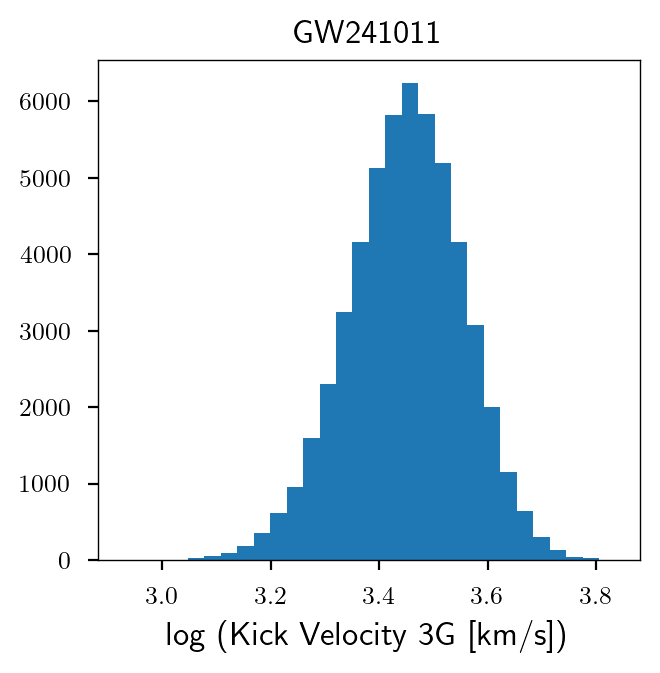

In [148]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(threeG_kick_GW241011), bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity 3G [km/s])')
plt.show()

In [8]:
f = open(GW241011_data_file)
data_GW241011 = json.load(f)
f.close()

In [9]:
f = open(GW241110_data_file)
data_GW241110 = json.load(f)
f.close()

In [10]:
data_GW241011['posterior']['content'].keys()

dict_keys(['mass_1_source', 'mass_ratio', 'a_1', 'a_2', 'cos_tilt_1', 'cos_tilt_2', 'phi_12', 'log_likelihood', 'log_prior', 'chi_eff', 'chi_p', 'final_mass_source', 'final_spin', 'final_kick'])

In [11]:
vr_post_GW241011 = np.array(data_GW241011['posterior']['content']['final_kick'])
vr_post_GW241110 = np.array(data_GW241110['posterior']['content']['final_kick'])

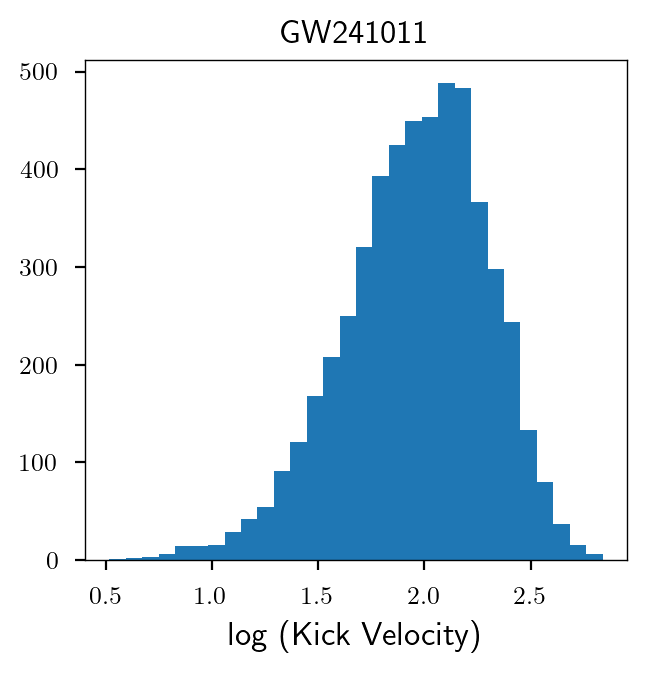

In [12]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241011), bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity)')
plt.show()

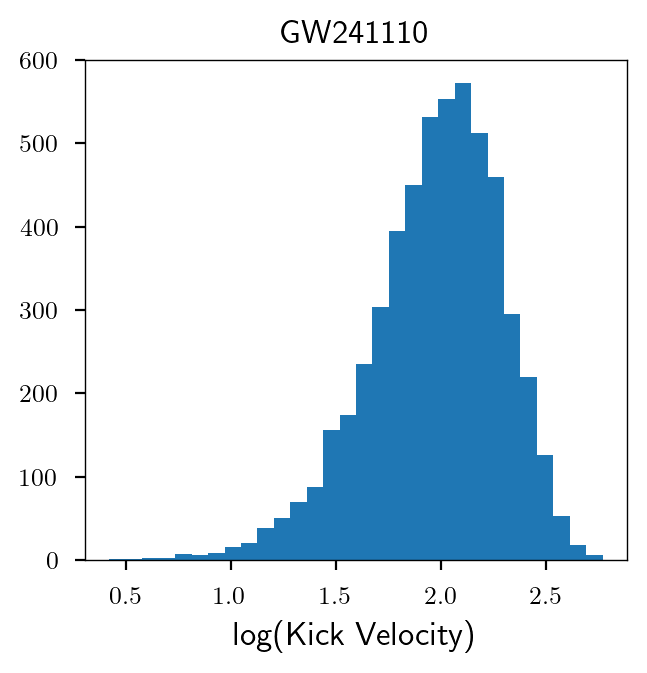

In [13]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241110), bins = 30)
plt.xlabel(r'log(Kick Velocity)')
plt.title(r'GW241110')
plt.show()

In [14]:
def get_v_esc(M0, a, r):
    psi = G * 10**M0 * M_sun / (a * PC) / np.sqrt(1 + (r / a)**2)
    return np.sqrt(2 * psi) / 1e3               # in km/s

In [15]:
def p_of_v(v, v_esc):
    x = v / v_esc
    p_v = 512 / 7 / np.pi / v_esc * x**2 * (1 - x**2)**7/2
    return p_v

In [16]:
def p_of_r(r, a):
    x = r / a
    return 3 * x**2 * (1 + x**2)**(-5/2) / a

In [17]:
def generate_samps_from_post(N, post):
    hist, bin_edges = np.histogram(post, bins=1000, density=True)
    cdf = np.cumsum(hist * np.diff(bin_edges))
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, bin_edges[1:])
    return samples

In [18]:
def generate_samps_from_dist(N, init_samp, pdf):
    init_samp_pdf = pdf(init_samp)
    cdf = integrate.cumulative_trapezoid(init_samp_pdf, init_samp, initial=0)
    cdf /= cdf[-1]
    u = np.random.rand(N)
    samples = np.interp(u, cdf, init_samp)
    return samples

In [646]:
np.random.seed(1234)

In [648]:
N = 100000
M0_samp = np.random.uniform(4, 10, N)            # M0 uniform in Log Space
a_samp = np.random.uniform(0.16, 1.5, N)
cos_theta_samp = np.random.uniform(-1, 1, N)

In [649]:
vr_samp_GW241011 = generate_samps_from_post(N, vr_post_GW241011)
vr_samp_GW241110 =  generate_samps_from_post(N, vr_post_GW241110)

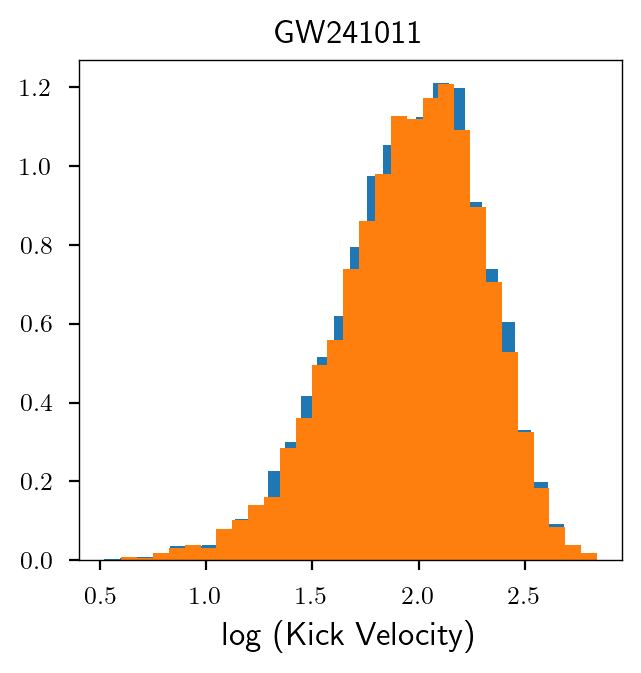

In [650]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(vr_post_GW241011), density = True, bins = 30)
plt.hist(np.log10(generate_samps_from_post(N, vr_post_GW241011)), density = True, bins = 30)
plt.title(r'GW241011')
plt.xlabel(r'log (Kick Velocity)')
plt.show()

In [654]:
r_init = np.linspace(0, 5, 1000)

In [655]:
#r_dist_func = lambda x: p_of_r(x, a_samp[0])
#generate_samps_from_dist(1, r_init, r_dist_func)

In [656]:
pofr_samps = p_of_r(r_init, a_samp[:, np.newaxis])

In [658]:
cdf_samps = integrate.cumulative_trapezoid(pofr_samps, r_init, initial=0, axis = -1)

In [660]:
cdf_samps = cdf_samps / cdf_samps[:, -1][:, None]

In [661]:
u = np.random.rand(N)

In [662]:
r_samp = np.array([np.interp(u[ii], cdf_samps[ii], r_init) for ii in tqdm(range(N))])

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 372449.28it/s]


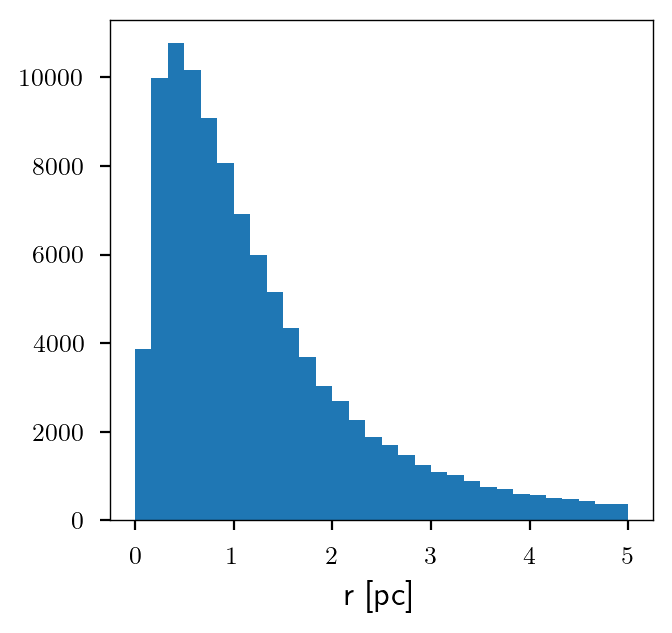

In [663]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp, bins = 30)
plt.xlabel(r'r [pc]')
plt.show()

In [664]:
v_esc_samp = get_v_esc(M0_samp, a_samp, r_samp)

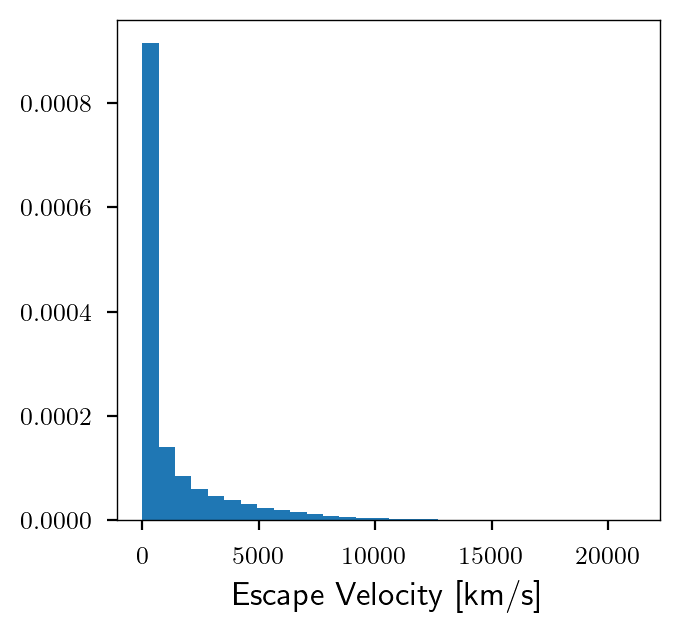

In [665]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_esc_samp, bins = 30, density = True)
plt.xlabel(r'Escape Velocity [km/s]')
plt.show()

In [666]:
v_init = np.linspace(0, v_esc_samp, 1000).T

In [667]:
pofv_samps = p_of_v(v_init, v_esc_samp[:, np.newaxis])

In [668]:
cdf_samps = integrate.cumulative_trapezoid(pofv_samps, v_init, initial=0, axis = -1)

In [669]:
cdf_samps = cdf_samps / cdf_samps[:, -1][:, None]

In [670]:
v_samp = np.array([np.interp(u[ii], cdf_samps[ii], v_init[ii]) for ii in tqdm(range(N))])

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:00<00:00, 127013.02it/s]


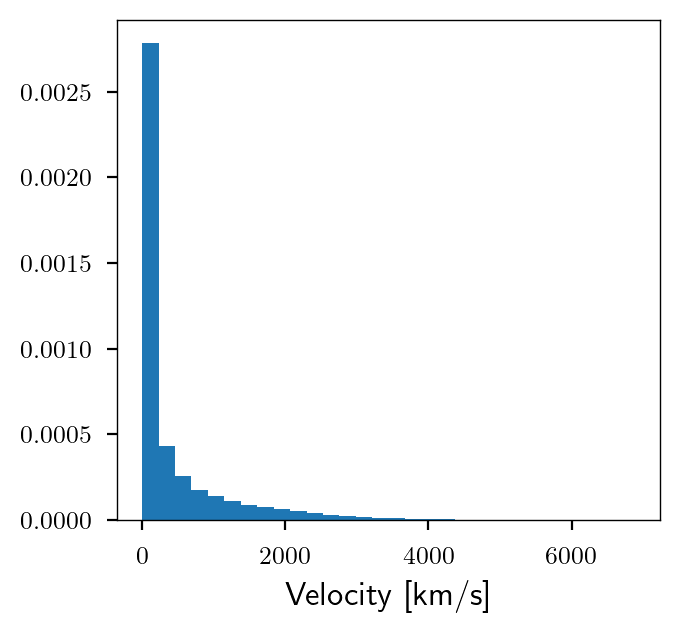

In [671]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_samp, bins = 30, density = True)
plt.xlabel(r'Velocity [km/s]')
plt.show()

In [672]:
v_true_GW241011 = np.sqrt(v_samp**2 + vr_samp_GW241011**2 + 2 * v_samp * vr_samp_GW241011 * cos_theta_samp)

In [673]:
v_true_GW241110 = np.sqrt(v_samp**2 + vr_samp_GW241110**2 + 2 * v_samp * vr_samp_GW241110 * cos_theta_samp)

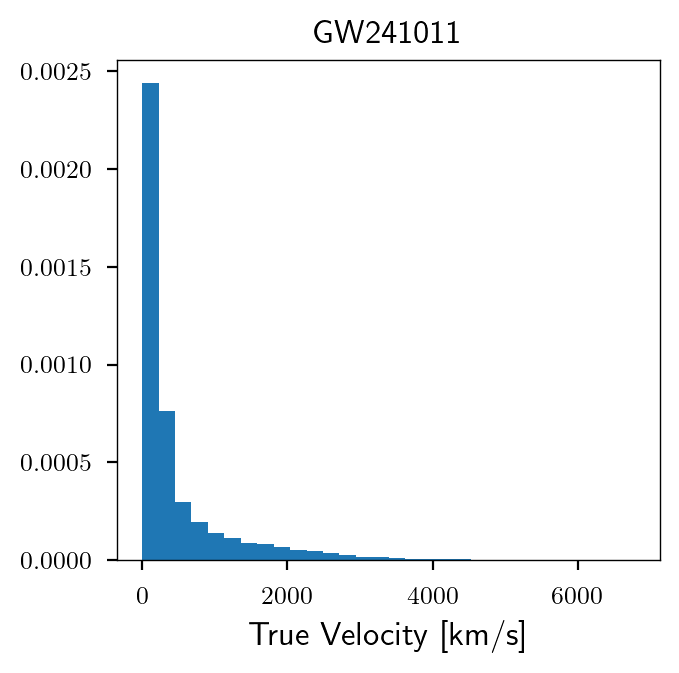

In [674]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_true_GW241011, bins = 30, density = True)
plt.xlabel(r'True Velocity [km/s]')
plt.title(r'GW241011')
plt.show()

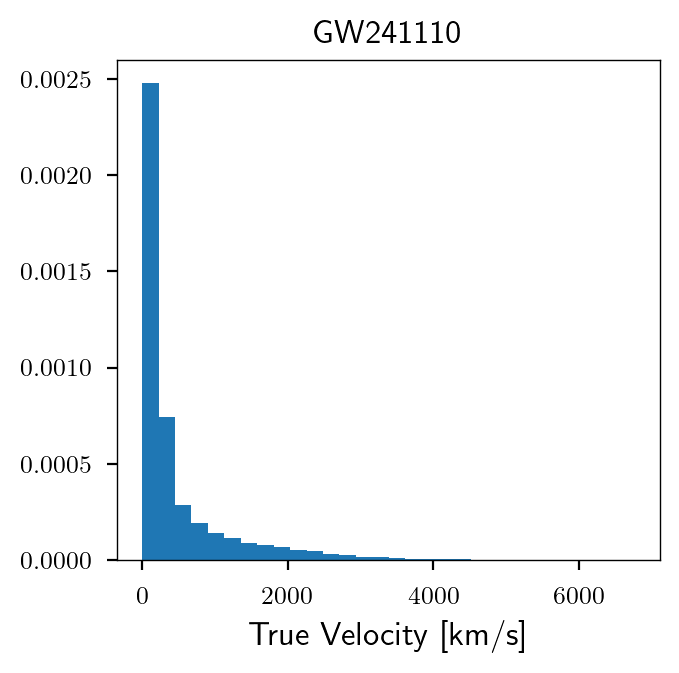

In [676]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(v_true_GW241110, bins = 30, density = True)
plt.xlabel(r'True Velocity [km/s]')
plt.title(r'GW241110')
plt.show()

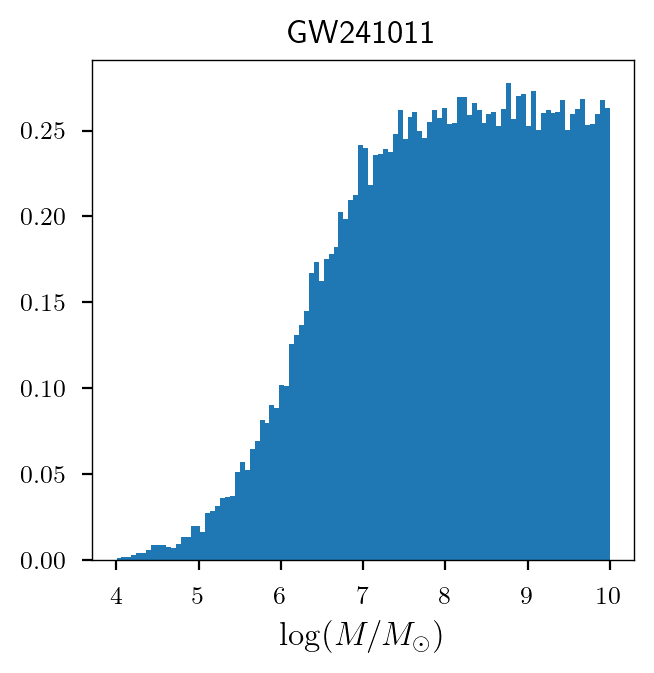

In [677]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_samp[np.where(v_true_GW241011 < v_esc_samp)], bins = 100, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.title(r'GW241011')
plt.show()

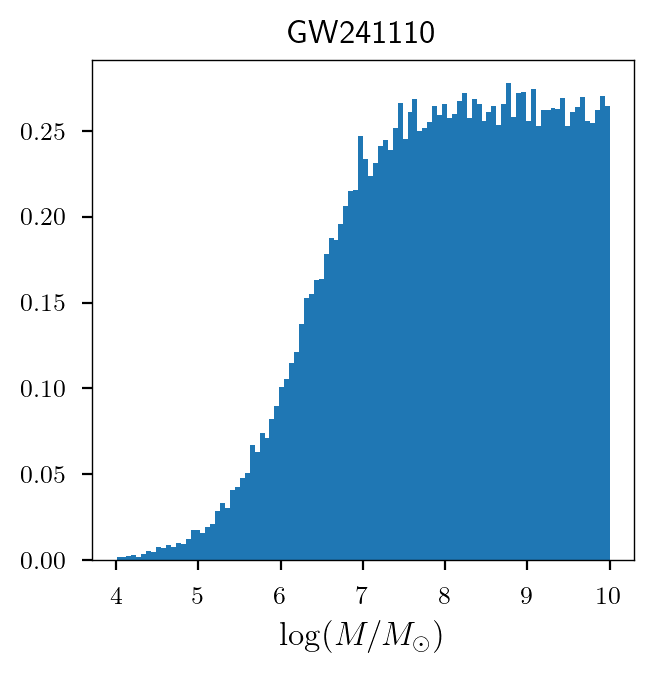

In [678]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_samp[np.where(v_true_GW241110 < v_esc_samp)], bins = 100, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.title(r'GW241110')
plt.show()

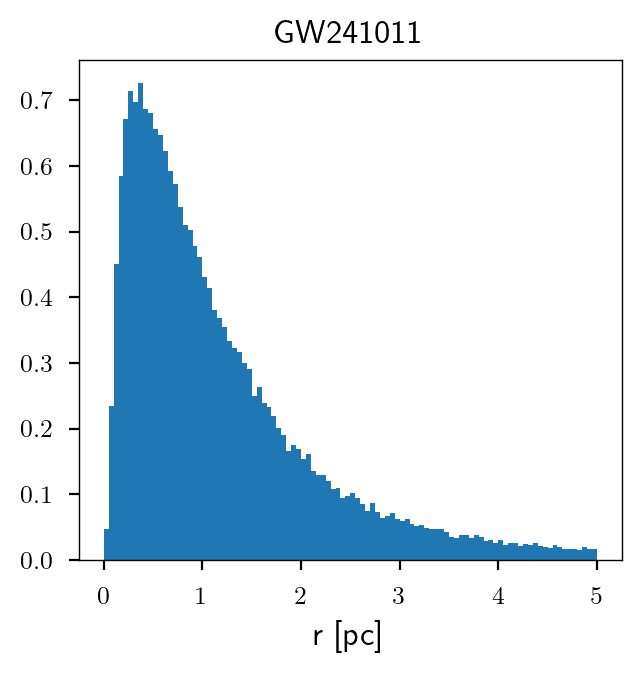

In [679]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp[np.where(v_true_GW241011 < v_esc_samp)], bins = 100, density = True)
plt.xlabel(r'r [pc]')
plt.title(r'GW241011')
plt.show()

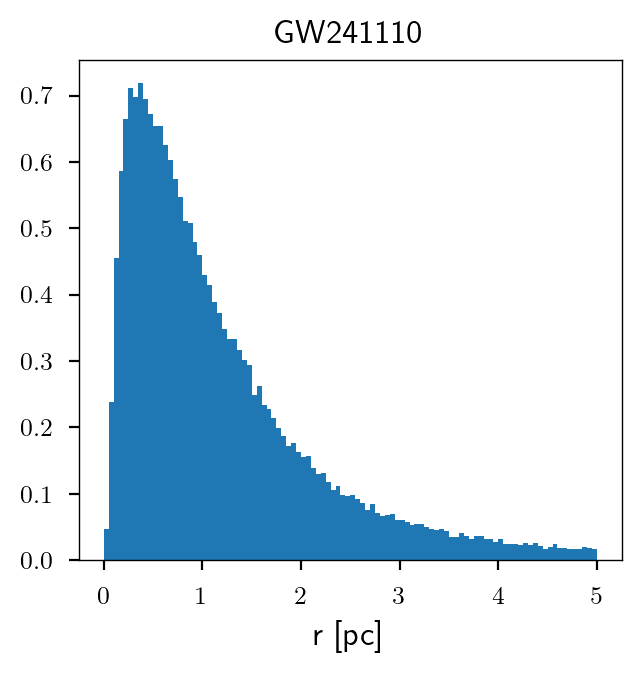

In [680]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp[np.where(v_true_GW241110 < v_esc_samp)], bins = 100, density = True)
plt.xlabel(r'r [pc]')
plt.title(r'GW241110')
plt.show()

## 3G

In [682]:
M0_ret_samp_GW241011 = M0_samp[np.where(v_true_GW241011 < v_esc_samp)]
a_ret_samp_GW241011 = a_samp[np.where(v_true_GW241011 < v_esc_samp)]

In [683]:
N_ret = len(M0_ret_samp_GW241011)

In [684]:
cos_theta_samp_new = np.random.uniform(-1, 1, N_ret)

In [685]:
vr_3G_samp_GW241011 = generate_samps_from_post(N_ret, threeG_kick_GW241011)

In [687]:
pofr_samps_new = p_of_r(r_init, a_ret_samp_GW241011[:, np.newaxis])
cdf_samps_new = integrate.cumulative_trapezoid(pofr_samps_new, r_init, initial=0, axis = -1)
cdf_samps_new = cdf_samps_new / cdf_samps_new[:, -1][:, None]
u_new = np.random.rand(N_ret)
r_samp_new = np.array([np.interp(u_new[ii], cdf_samps_new[ii], r_init) for ii in tqdm(range(N_ret))])

100%|████████████████████████████████████████████████████████████████████████████| 63832/63832 [00:00<00:00, 379215.67it/s]


In [689]:
v_esc_ret_samp = get_v_esc(M0_ret_samp_GW241011, a_ret_samp_GW241011, r_samp_new)

In [691]:
v_init_ret = np.linspace(0, v_esc_ret_samp, 1000).T
pofv_samps_new = p_of_v(v_init_ret, v_esc_ret_samp[:, np.newaxis])
cdf_samps_new = integrate.cumulative_trapezoid(pofv_samps_new, v_init_ret, initial=0, axis = -1)
cdf_samps_new = cdf_samps_new / cdf_samps_new[:, -1][:, None]

In [692]:
v_samp_ret = np.array([np.interp(u_new[ii], cdf_samps_new[ii], v_init_ret[ii]) for ii in tqdm(range(N_ret))])

100%|████████████████████████████████████████████████████████████████████████████| 63832/63832 [00:00<00:00, 153976.51it/s]


In [693]:
v_true_ret_GW241011 = np.sqrt(v_samp_ret**2 + vr_3G_samp_GW241011**2 + 2 * v_samp_ret * vr_3G_samp_GW241011 * cos_theta_samp_new)

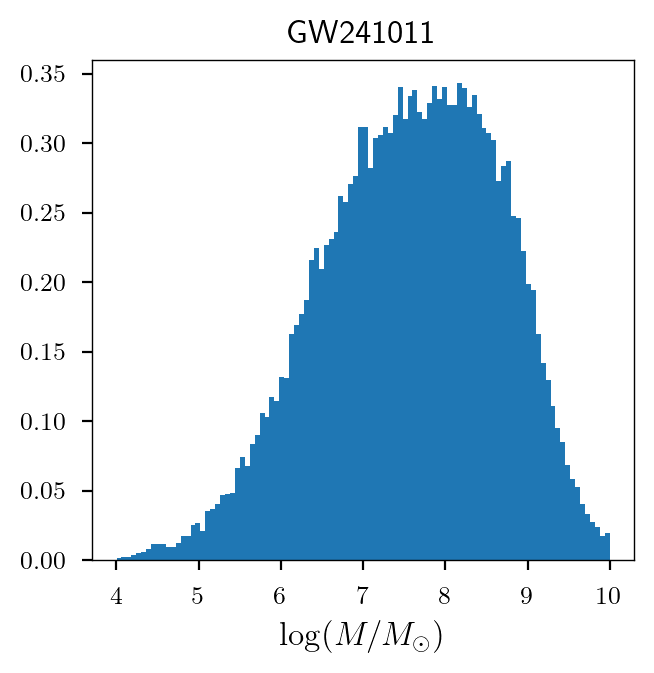

In [694]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], bins = 100, density = True)
#plt.hist(10**(M0_samp[idx]), bins = 1000, density = True)
#plt.xscale('log')
plt.xlabel(r'$\log(M / M_{\odot})$')
plt.title(r'GW241011')
plt.show()

In [695]:
np.median(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)])

7.644173964983397

In [696]:
np.quantile(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], 0.05)

5.738897735139137

In [697]:
np.quantile(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], 0.95)

9.18700614115359

In [698]:
np.quantile(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], 0.16)

6.4583780075586645

In [699]:
np.quantile(M0_ret_samp_GW241011[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], 0.84)

8.696135716738068

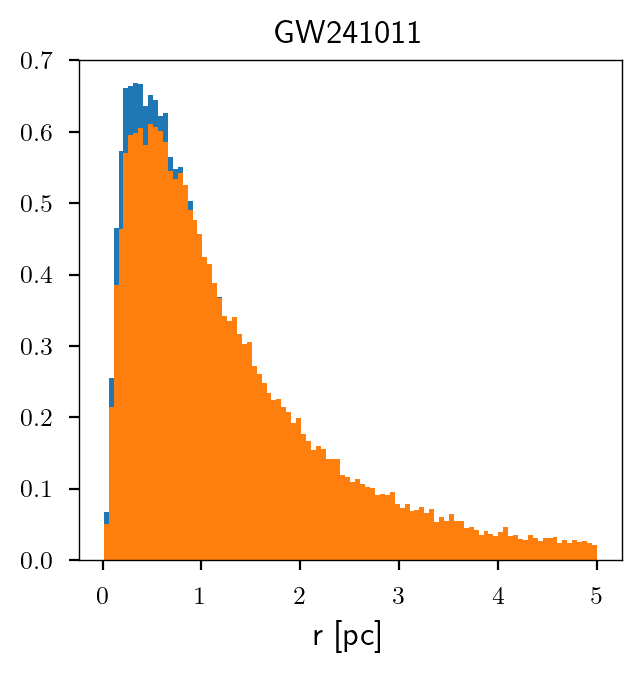

In [702]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(r_samp_new, bins = 100, density = True)
plt.hist(r_samp_new[np.where(v_true_ret_GW241011 >= v_esc_ret_samp)], bins = 100, density = True)
plt.xlabel(r'r [pc]')
plt.title(r'GW241011')
plt.show()

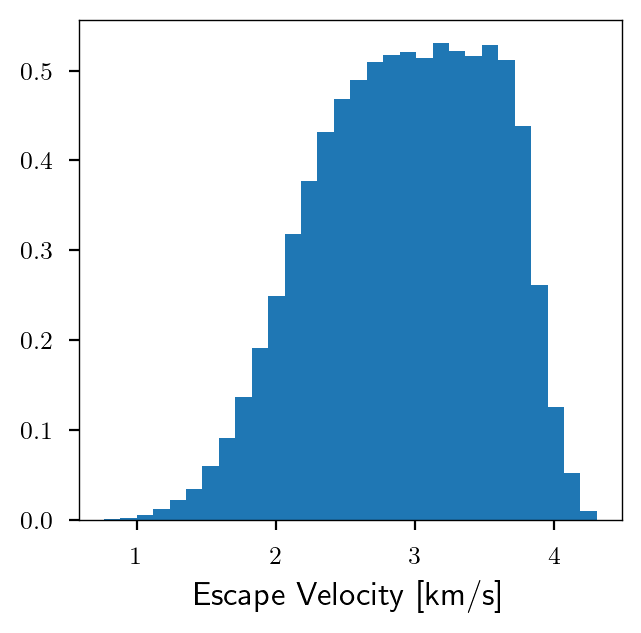

In [704]:
plt.figure(frameon=False, figsize=(3.5, 3.25), dpi=200)

plt.hist(np.log10(v_esc_ret_samp), bins = 30, density = True)
#plt.xscale('log')
plt.xlabel(r'Escape Velocity [km/s]')
plt.show()